In [1]:
%load_ext autoreload
%autoreload 2

# Swyft in 15 Minutes

We discuss seven key steps of a typical Swyft workflow.

## 1. Installing Swyft

We can use `pip` to install the lightning branch (latest development branch) of Swyft.

In [2]:
#!pip install https://github.com/undark-lab/swyft.git@lightning

In [3]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft

## 2. Define the Simulator

Next we define a simulator class, which specifies the computational graph of our simulator.

In [4]:
class Simulator(swyft.Simulator):
    def __init__(self):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.x = np.linspace(-1, 1, 10)
         
    def build(self, graph):
        z = graph.node('z', lambda: np.random.rand(2)*2-1)
        f = graph.node('f', lambda z: z[0] + z[1]*self.x, z)
        x = graph.node('x', lambda f: f + np.random.randn(10)*0.1, f)
        
sim = Simulator()
samples = sim.sample(N = 10000)

100%|██████████| 10000/10000 [00:00<00:00, 40216.54it/s]


## 3. Define the SwyftModule

In [5]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Linear(10, 2)
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 2, num_params = 2, varnames = 'z')
        self.logratios2 = swyft.LogRatioEstimator_Ndim(num_features = 2, marginals = ((0, 1),), varnames = 'z')

    def forward(self, A, B):
        embedding = self.embedding(A['x'])
        logratios1 = self.logratios1(embedding, B['z'])
        logratios2 = self.logratios2(embedding, B['z'])
        return logratios1, logratios2

## 4. Train the model

In [6]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.1, 0.1], batch_size = 64, num_workers = 3)

In [8]:
network = Network()
trainer.fit(network, dm)

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/weniger/codes/swyft/notebooks/lightning_logs/version_10034687/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params
------------------------------------------------------
0 | embedding  | Linear                 | 22    
1 | logratios1 | LogRatioEstimator_1dim | 34.9 K
2 | logratios2 | LogRatioEstimator_Ndim | 17.5 K
------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.210     Total estimated model params size (MB)


Epoch 0:  89%|████████▊ | 125/141 [00:02<00:00, 57.59it/s, loss=-2.99, v_num=1e+7]
Validation: 0it [00:00, ?it/s]
Epoch 1:  89%|████████▊ | 125/141 [00:02<00:00, 56.29it/s, loss=-3.11, v_num=1e+7, val_loss=-3.03]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 141/141 [00:02<00:00, 53.38it/s, loss=-3.11, v_num=1e+7, val_loss=-3.11]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 141/141 [00:02<00:00, 52.81it/s, loss=-3.11, v_num=1e+7, val_loss=-3.11]


## 5. Visualize training

N/A

## 6. Perform validation tests

In [9]:
trainer.test(network, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 162.68it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    -3.0958783626556396    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -3.0958783626556396}]

In [10]:
B = samples[:1000]
A = samples[:1000]
mass = trainer.test_coverage(network, A, B)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 32/32 [00:00<00:00, 202.16it/s]


/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1000/1000 [00:13<00:00, 72.18it/s]


## 7. Generate posteriors

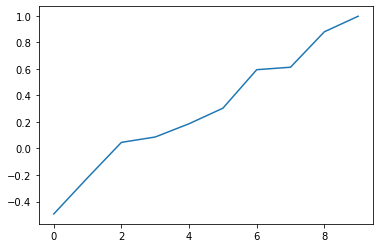

In [11]:
z0 = np.array([0.3, 0.7])
x0 = sim.sample(conditions = {"z": z0})['x']
plt.plot(x0)

In [12]:
prior_samples = sim.sample(targets = ['z'], N = 100000)

100%|██████████| 100000/100000 [00:01<00:00, 98539.19it/s]


In [13]:
predictions = trainer.infer(network, swyft.Sample(x = x0), prior_samples)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 127.59it/s]


In [14]:
predictions[0].parnames

array([['z[0]'],
       ['z[1]']], dtype='<U4')

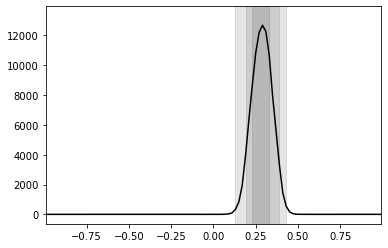

In [15]:
swyft.plot_1d(predictions, 'z[0]', ax = plt.gca())

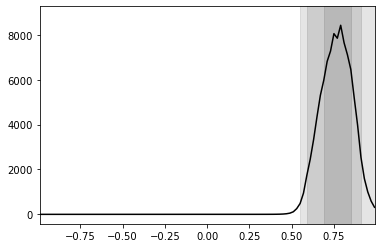

In [16]:
swyft.plot_1d(predictions, 'z[1]', ax = plt.gca())